# Estimation of a imputer model to compute household spending at census level

#### Loading packages

In [1]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import expr


from sklearn.preprocessing import StandardScaler


import time
import numpy as np
import pandas as pd

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderModel
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

In [ ]:
from keras.layers import Input, Dense, Flatten, concatenate, Lambda
from keras.layers import Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.activations import softmax
from keras.backend import slice
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasRegressor

#### Data prcessing

###### Loading database - Dependent variable (Spending)

In [3]:
# Create an DataFrame from file_path
bdOriginal = spark.read.csv(r"C:\Users\eo\Documents\003_Market_Trends\002_Bases\bd_gastos.csv", header=True)

bdOriginal = bdOriginal.withColumn("gasto", bdOriginal.gasto.cast(DoubleType()))

###### Processing data at category level per period

In [11]:
bdGastosDetalle = (bdOriginal
                   .groupBy(['conglome','vivienda','hogar','CODIGO_MT','periodo'])
                   .agg({'gasto':'sum'})
                   .withColumnRenamed('sum(gasto)','gasto')
                  )
bdGastosAgregados = (bdGastosDetalle
                     .groupBy(['conglome','vivienda','hogar','periodo'])
                     .agg({'gasto':'sum'})
                     .withColumnRenamed('sum(gasto)','gastoAgregado')
                    )

bdGastosConsolidado = (bdGastosDetalle
                       .join(bdGastosAgregados, on = ['conglome','vivienda','hogar','periodo'])
                      )

bdGastosConsolidado = (bdGastosConsolidado
                       .withColumn("PorcentajeGasto", 
                                   bdGastosConsolidado['gasto']/bdGastosConsolidado['gastoAgregado'])
                      )

bdParticipacionGasto = (bdGastosConsolidado
                        .select(['conglome','vivienda','hogar','periodo','CODIGO_MT','PorcentajeGasto'])
                        .groupby(['conglome','vivienda','hogar','periodo'])
                        .pivot('CODIGO_MT')
                        .mean('PorcentajeGasto')
                       )
bdParticipacionGasto = (bdParticipacionGasto
                        .join(bdGastosAgregados, 
                              on = ['conglome','vivienda','hogar','periodo'])
                       )
bdParticipacionGasto = bdParticipacionGasto.fillna(0)

ListaGrupos = np.unique([x[:3] for x in bdParticipacionGasto.drop('conglome','vivienda','hogar','periodo').columns])
Categorias = {x: [z for z in bdParticipacionGasto.drop('conglome','vivienda','hogar','periodo').columns if x + '_' in z] for x in ListaGrupos}

bdParticipacionAgregado = bdParticipacionGasto
for Categoria in Categorias:
    if len(Categorias[Categoria])>0:
        bdParticipacionAgregado = (bdParticipacionAgregado
                                   .withColumn(Categoria, expr('+'.join(Categorias[Categoria])))
                                  )

DetalleParticipaciones = bdParticipacionGasto.columns[4:-1]
bdParticipacionAgregado = bdParticipacionAgregado.drop(*DetalleParticipaciones)

###### Loading independent variables

In [13]:
bd_X = (spark.read.csv(r"C:\Users\eo\Documents\003_Market_Trends\001_ENAHO_Representatividad\bd_enaho_X.csv", 
                       header=True)
       )
for Variable in [var for var in bd_X.columns if 'var_' in var]:
    bd_X = bd_X.withColumn(Variable, bd_X[Variable].cast(DoubleType()))

bdConsolidada = (bdParticipacionAgregado
                 .join(bd_X, 
                       on = ['conglome','vivienda','hogar','periodo'])
                 .dropna()
                )

###### Region encoding

In [18]:
bdConsolidada = bdConsolidada.withColumn("CCDD",bdConsolidada.ubigeo[0:2])

stringIndexer = StringIndexer(inputCol="CCDD", outputCol="CCDDIndex")
model = stringIndexer.fit(bdConsolidada)
indexed = model.transform(bdConsolidada)

encoder = OneHotEncoder(inputCol="CCDDIndex", outputCol="CCDDVec").fit(indexed)
encoded = encoder.transform(indexed)


var_X = [var for var in encoded.columns if 'var' in var]
vectorAssembler = VectorAssembler(inputCols = var_X  + ['CCDDVec'] , outputCol = 'features')
assembled = vectorAssembler.transform(encoded)

#### Model estimation

###### Train/Test

In [19]:
bdTrain, bdTest = assembled.randomSplit([0.75, 0.25], seed=1109)

In [20]:
bdTrain_ = bdTrain.toPandas()
bdTest_ = bdTest.toPandas()

###### Designing the neural network to predict the model (final version)

In [21]:
input_dim = len(var_X)
n_ccdd = len(np.unique(bdTest_['CCDD']))

In [22]:
varGasto = ['gastoAgregadoPreprocess']
varDetalle = bdParticipacionAgregado.columns[5:]

In [24]:
ss = StandardScaler()
bdTrain_['gastoAgregadoPreprocess'] = ss.fit_transform(np.log(bdTrain_[['gastoAgregado']]+1))
bdTest_['gastoAgregadoPreprocess'] = ss.fit_transform(np.log(bdTest_[['gastoAgregado']]+1))

###### NN structure

In [26]:
#Embedding
ccdd_emb_layer = Embedding(input_dim=n_ccdd+1,
                        output_dim=3,
                        input_length=1,
                        name='CCDD')
input_ccdd = Input(shape = (1,))
ccdd_emb = Flatten()(ccdd_emb_layer(input_ccdd))

#Input data
input_tensor = Input(shape=(input_dim,))

#Layers
layer1 = concatenate([input_tensor,ccdd_emb])
layer2 = Dense(100, activation = 'linear')(layer1)
layer3 = Dense(100, activation = 'relu')(layer2)
layer4 = Dense(100, activation = 'relu')(layer3)
layer5 = Dense(50, activation = 'relu')(layer4)
layer6 = Dense(50, activation = 'relu')(layer5)
layer7 = Dense(50, activation = 'relu')(layer6)



#Output
output_tensor = Dense(1)(layer3)
output_P = Dense(len(varDetalle))(layer7)
output_NormP = Dense(len(varDetalle), activation = 'softmax')(output_P)

# Build the model
model = Model([input_ccdd, input_tensor], [output_tensor,output_NormP])

model.compile(loss = tf.keras.losses.LogCosh(), loss_weights = [1, 100], optimizer='sgd')

###### Fitting

In [28]:
model.fit([bdTrain_['CCDD'], bdTrain_[var_X]],
          [bdTrain_[varGasto],bdTrain_[varDetalle]],
          epochs=1000,
          batch_size=1000,
          validation_split=0.1,

          verbose=True)

C:\Users\eo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 173655 samples, validate on 19295 samples
Epoch 1/1000
173655/173655 [==============================] - 1s 8us/step - loss: 1.2210 - dense_7_loss: 0.7702 - dense_9_loss: 0.0045 - val_loss: 0.6084 - val_dense_7_loss: 0.2138 - val_dense_9_loss: 0.0040
Epoch 2/1000
173655/173655 [==============================] - 1s 7us/step - loss: 0.6317 - dense_7_loss: 0.2384 - dense_9_loss: 0.0039 - val_loss: 0.5912 - val_dense_7_loss: 0.2051 - val_dense_9_loss: 0.0039
Epoch 3/1000
173655/173655 [==============================] - 1s 6us/step - loss: 0.6021 - dense_7_loss: 0.2158 - dense_9_loss: 0.0039 - val_loss: 0.5587 - val_dense_7_loss: 0.1817 - val_dense_9_loss: 0.0038
Epoch 4/1000
173655/173655 [==============================] - 1s 7us/step - loss: 0.5829 - dense_7_loss: 0.2022 - dense_9_loss: 0.0038 - val_loss: 0.5575 - val_dense_7_loss: 0.1792 - val_dense_9_loss: 0.0038
Epoch 5/1000
173655/173655 [==============================] - 1s 7us/step - loss: 0.5690 - dense_7_loss: 0.1921 - den

In [29]:
print(model
      .evaluate([bdTest_['CCDD'], bdTest_[var_X]], 
                [bdTest_[varGasto],bdTest_[varDetalle]], 
                verbose=False)
     )
model.predict([bdTest_['CCDD'],bdTest_[var_X]])

[0.40759643696706827, 0.10556522756814957, 0.003020384581759572]


[array([[-0.6114308 ],
        [-0.45889026],
        [ 1.1724229 ],
        ...,
        [ 0.6591316 ],
        [ 0.23054534],
        [-0.60665154]], dtype=float32),
 array([[0.22596076, 0.39240062, 0.00433953, ..., 0.03406114, 0.04860461,
         0.04357196],
        [0.15612231, 0.39768535, 0.00837134, ..., 0.04264737, 0.06337003,
         0.06636862],
        [0.15853132, 0.24499099, 0.01365287, ..., 0.05912387, 0.0454657 ,
         0.11450675],
        ...,
        [0.11590124, 0.39346883, 0.00711032, ..., 0.04126853, 0.052807  ,
         0.10657476],
        [0.14909527, 0.46789512, 0.0032087 , ..., 0.04564899, 0.06626664,
         0.0708442 ],
        [0.14041933, 0.4310687 , 0.00498485, ..., 0.0217095 , 0.03468152,
         0.03945887]], dtype=float32)]

#### Check output prediction

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

###### Checking aggregate statistics

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


       gastoAgregadoPreprocess  gastoAgregadoPreprocess_p
count             6.460600e+04               64606.000000
mean             -4.340844e-16                  -0.018325
std               1.000008e+00                   0.855817
min              -1.001483e+01                  -2.931516
25%              -5.960373e-01                  -0.596819
50%               1.176456e-01                   0.070297
75%               6.921019e-01                   0.617935
max               3.282284e+00                   2.501944
0.6941620641395179


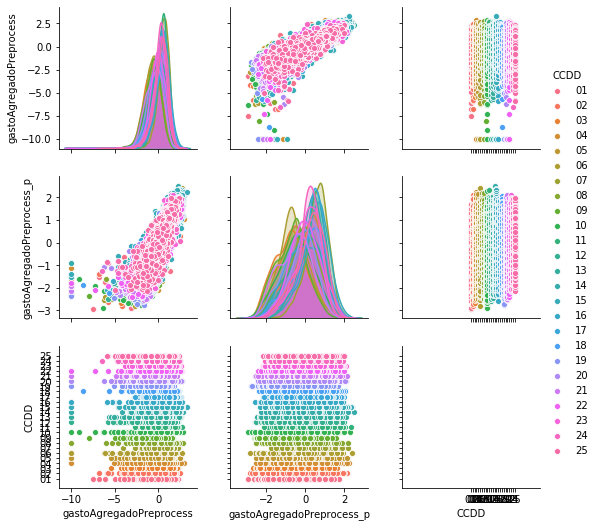

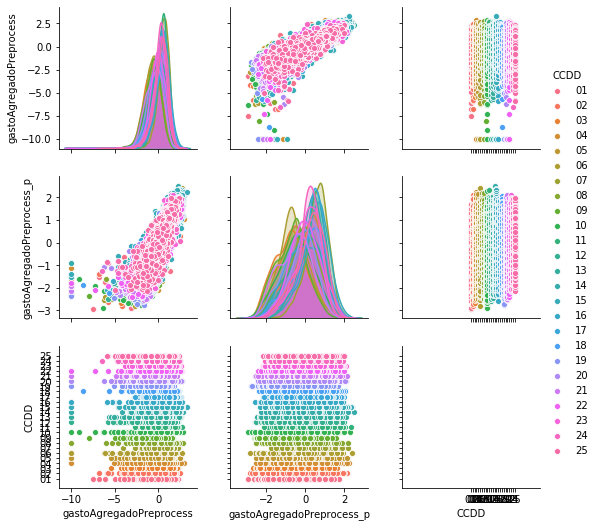

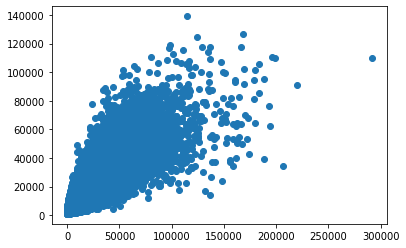

In [31]:
bdTest_[varGasto[0] + '_p'] = model.predict([bdTest_['CCDD'],bdTest_[var_X]])[0]
sns.pairplot(bdTest_[[varGasto[0],varGasto[0] + '_p','CCDD']],hue='CCDD')
sns.pairplot(
    bdTest_[[varGasto[0],varGasto[0] + '_p','CCDD']],hue='CCDD')

print(bdTest_[[varGasto[0],varGasto[0] + '_p']].describe())
print(r2_score(
    np.exp(ss.inverse_transform(bdTest_[varGasto[0]])),
    np.exp(ss.inverse_transform(bdTest_[varGasto[0] + '_p']))
    ))
plt.show()
plt.scatter(np.exp(ss.inverse_transform(bdTest_[varGasto[0]])),
    np.exp(ss.inverse_transform(bdTest_[varGasto[0] + '_p'])))

###### Check predicted aggregate by region and period

In [32]:
bdGastos = pd.DataFrame({'Gasto':np.exp(ss.inverse_transform(bdTest_[varGasto[0]])),
                         'Gasto P': np.exp(ss.inverse_transform(bdTest_[varGasto[0] + '_p'])),
                         'CCDD':bdTest_['CCDD'],
                         'Periodo':bdTest_['periodo']}
                       )

In [33]:
bdGastos.groupby(['CCDD','Periodo']).mean()

Gasto       Gasto P
CCDD Periodo                            
01   2012     11910.713544  10414.579102
     2013     11205.316150  10946.784180
     2014     12122.386593  11141.612305
     2015     12340.914589  10922.908203
     2016     12830.090007  10697.371094
...                    ...           ...
25   2015     21819.940215  19656.171875
     2016     21169.953082  20461.630859
     2017     23332.347609  21176.271484
     2018     21172.664269  20787.195312
     2019     21031.359295  20073.900391

[200 rows x 2 columns]

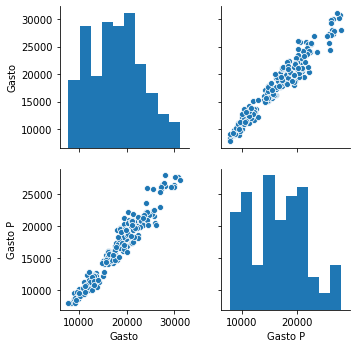

In [34]:
sns.pairplot(bdGastos.groupby(['CCDD','Periodo']).mean())

###### Check the statistics by category

ALF


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                ALF         ALF_p
count  64606.000000  64606.000000
mean       0.183377      0.180583
std        0.178757      0.080115
min        0.000000      0.041139
25%        0.040174      0.129481
50%        0.134857      0.163894
75%        0.274165      0.210394
max        1.000000      0.808845


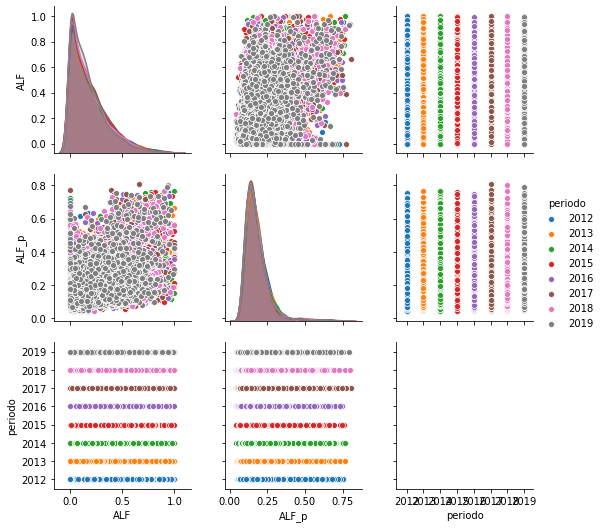

0.1968644695388032
ALI


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                ALI         ALI_p
count  64606.000000  64606.000000
mean       0.352248      0.372209
std        0.173611      0.093425
min        0.000000      0.042936
25%        0.227091      0.313261
50%        0.345126      0.376379
75%        0.470704      0.436877
max        1.000000      0.664966


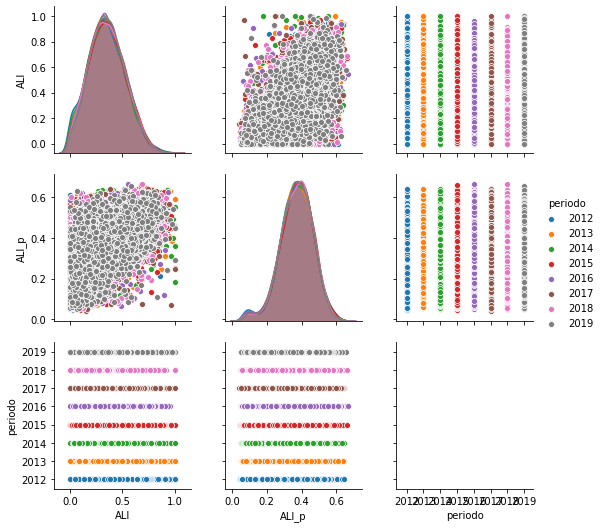

0.25229941110904874
ALQ


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                ALQ         ALQ_p
count  64606.000000  64606.000000
mean       0.021762      0.018768
std        0.059675      0.039547
min        0.000000      0.000372
25%        0.000000      0.003870
50%        0.000000      0.006537
75%        0.003799      0.012334
max        0.810848      0.499155


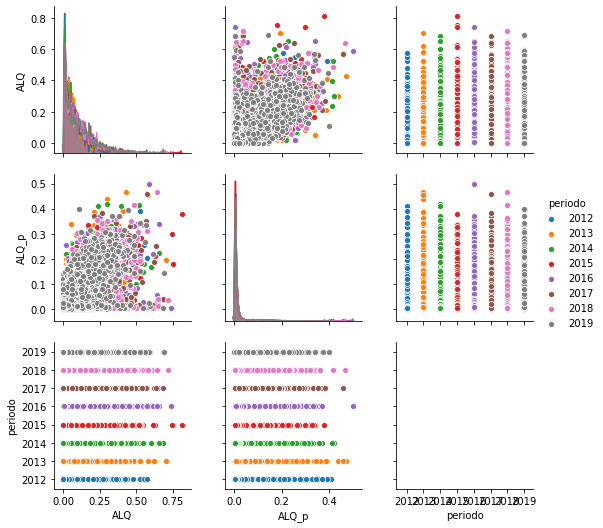

0.48727517997551584
COM


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                COM         COM_p
count  64606.000000  64606.000000
mean       0.038849      0.036644
std        0.039550      0.022864
min        0.000000      0.002443
25%        0.011167      0.019108
50%        0.028901      0.031578
75%        0.055119      0.049801
max        0.682713      0.169354


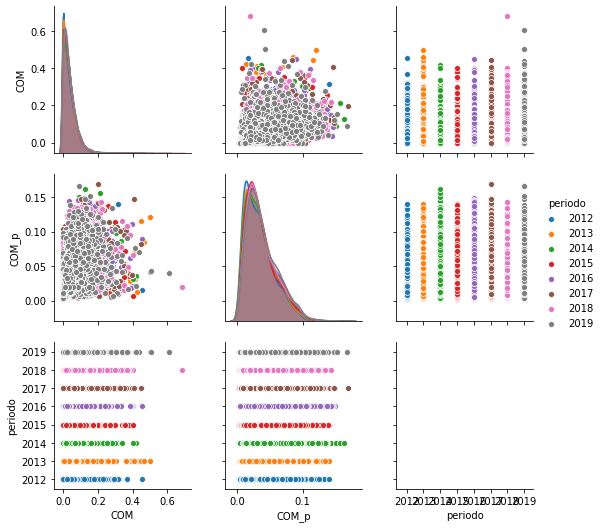

0.34572439148360934
CON


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                CON         CON_p
count  64606.000000  64606.000000
mean       0.061993      0.062107
std        0.049794      0.015172
min        0.000000      0.018815
25%        0.033935      0.052111
50%        0.052139      0.060274
75%        0.076878      0.069374
max        1.000000      0.176746


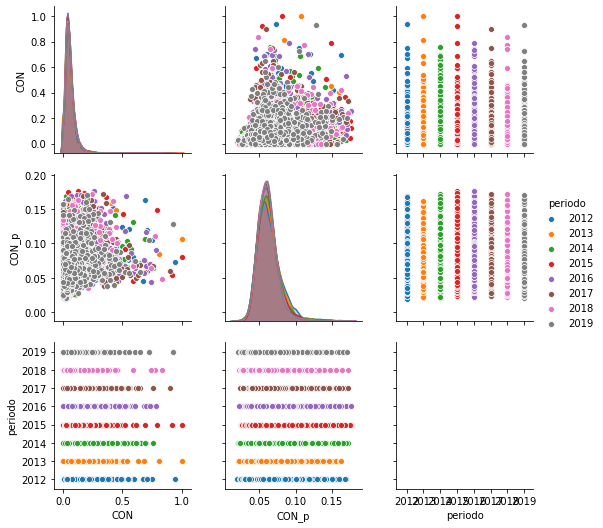

0.09207615116105938
EDU


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                EDU         EDU_p
count  64606.000000  64606.000000
mean       0.034752      0.036045
std        0.059923      0.036497
min        0.000000      0.000444
25%        0.000000      0.009745
50%        0.011751      0.025462
75%        0.038376      0.048880
max        0.605169      0.338942


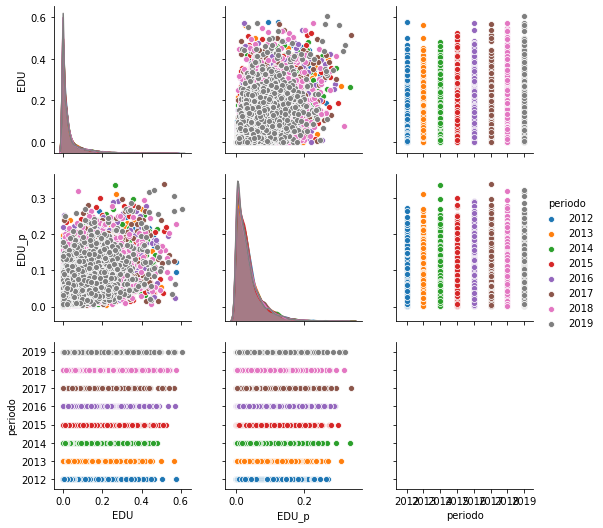

0.3878410219698698
ENT


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                ENT         ENT_p
count  64606.000000  64606.000000
mean       0.010135      0.009375
std        0.024490      0.004965
min        0.000000      0.001226
25%        0.000000      0.005863
50%        0.002928      0.008395
75%        0.010972      0.011762
max        0.756188      0.038847


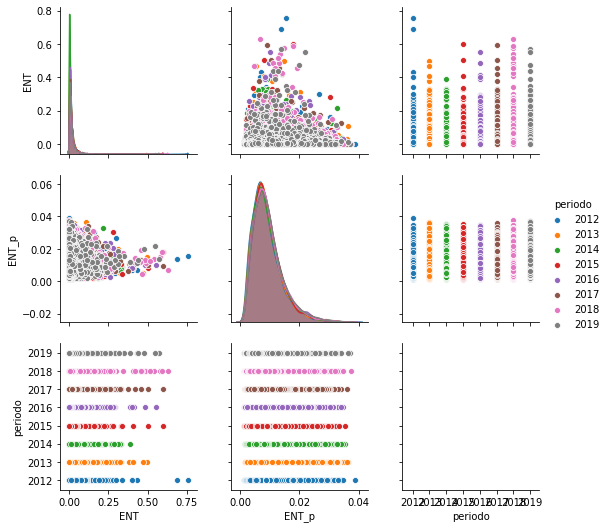

0.002893591586639488
OTR


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                OTR         OTR_p
count  64606.000000  64606.000000
mean       0.051646      0.049749
std        0.046663      0.014795
min        0.000000      0.015253
25%        0.023132      0.039704
50%        0.041623      0.047577
75%        0.067165      0.056723
max        1.000000      0.173175


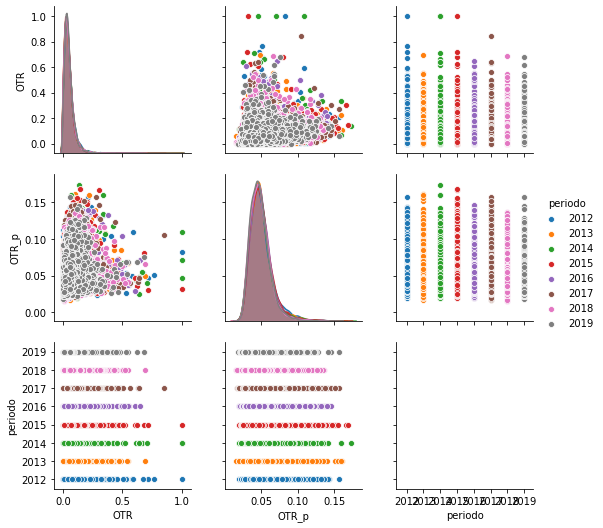

0.10077253181959711
RET


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                RET         RET_p
count  64606.000000  64606.000000
mean       0.059476      0.054562
std        0.057477      0.019262
min        0.000000      0.012540
25%        0.017849      0.040308
50%        0.045906      0.053192
75%        0.084344      0.066262
max        1.000000      0.157889


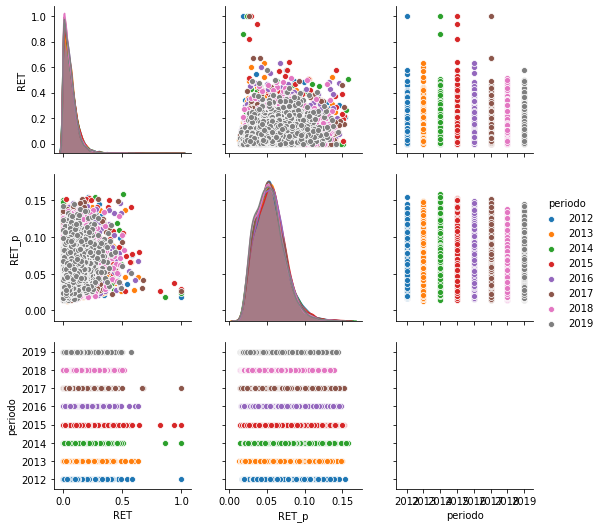

0.11462919163810492
SAL


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                SAL         SAL_p
count  64606.000000  64606.000000
mean       0.045476      0.044913
std        0.075704      0.013538
min        0.000000      0.012732
25%        0.002383      0.035094
50%        0.017016      0.042831
75%        0.054492      0.052575
max        1.000000      0.114613


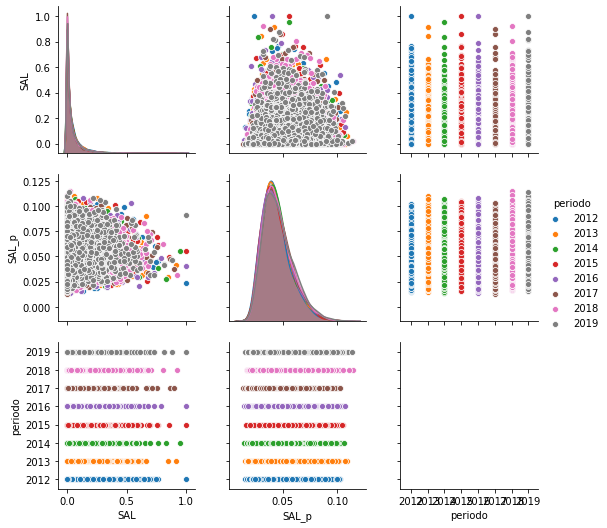

0.038786641654092846
SER


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                SER         SER_p
count  64606.000000  64606.000000
mean       0.060676      0.063705
std        0.053101      0.024973
min        0.000000      0.009323
25%        0.029535      0.047053
50%        0.049505      0.059424
75%        0.076746      0.074709
max        1.000000      0.171575


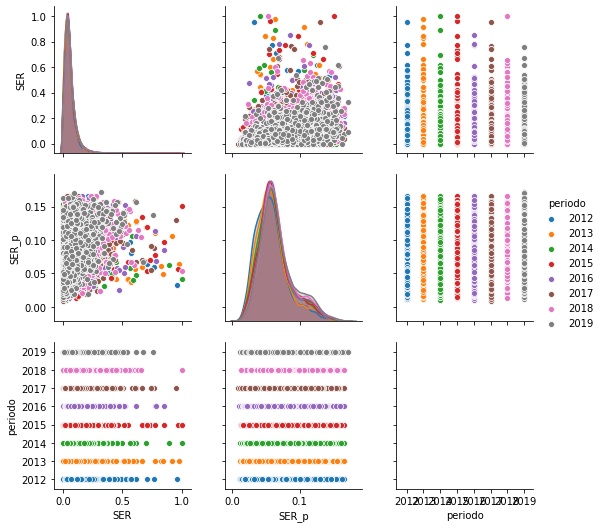

0.22409761506851966
TRA


C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


                TRA         TRA_p
count  64606.000000  64606.000000
mean       0.079333      0.071340
std        0.075032      0.027242
min        0.000000      0.016825
25%        0.026107      0.051074
50%        0.063466      0.066203
75%        0.111415      0.086647
max        1.000000      0.340754


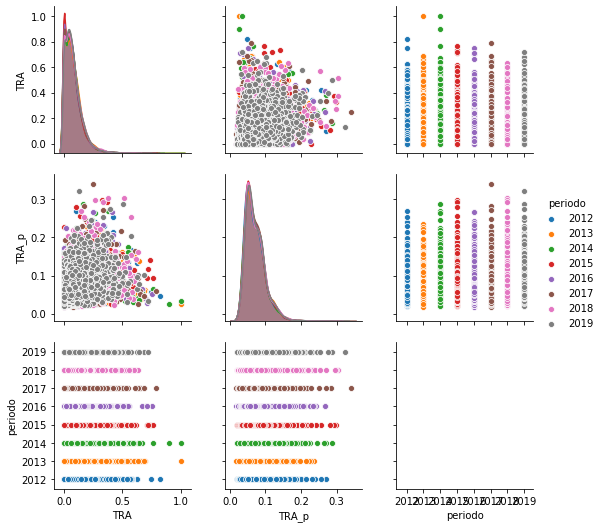

0.12687755757161523


In [35]:

for i,x in enumerate(varDetalle):
    bdTest_[x + '_p'] = model.predict([bdTest_['CCDD'],bdTest_[var_X]])[1][:,i]
    print(x)
    sns.pairplot(bdTest_[[x,x+'_p','periodo']],hue='periodo')
    print(bdTest_[[x,x+'_p']].describe())
    plt.show()
    print(r2_score(bdTest_[x],bdTest_[x+'_p']))
    

###### Making a dummy model as a benchmark, to compare prediction capacity

In [36]:
from sklearn.linear_model import LinearRegression


for x in varDetalle:

    lreg = LinearRegression()

    lreg.fit(bdTrain_[var_X],bdTrain_[x])
    print(x)
    print(lreg.score(bdTest_[var_X],bdTest_[x]))

ALF
0.15862314399797384
ALI
0.21421073871911744
ALQ
0.44896331632661246
COM
0.38960149274839195
CON
0.08164381988470659
EDU
0.32668258505297154
ENT
0.054416466505008865
OTR
0.09329813650398
RET
0.118902387487005
SAL
0.037007807757122424
SER
0.2231309586762279
TRA
0.1364013761007723


#### Saving models

In [37]:
# save model structure to JSON (no weights)
model_json = model.to_json()
with open("ModeloGastos.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('PesosModelo.h5')

In [38]:
#Saving Scaler
import pickle
scaler = 'ScalerGastos.pkl'  
vectorInputs = 'Inputs.pkl'
vectorOutputs = 'Outputs.pkl'

with open(scaler, 'wb') as file:
    pickle.dump(ss, file)

varInputs = [['CCDD'], [var_X]]
    
varOutputs = [[varGasto],[varDetalle]]


with open(vectorInputs, 'wb') as file:
    pickle.dump(varInputs, file)
    
with open(vectorOutputs, 'wb') as file:
    pickle.dump(varOutputs, file)